In [1]:
import requests
import getpass
import socket 
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import re
import time
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
# fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth
from xml.etree import ElementTree as ET
import sys
import numpy as np
%matplotlib inline

In [2]:
sys.path.insert(1, '/Users/parndt/Vault/') # the path here needs to match the one on which earthdatacreds.py is stored
import earthdatacreds
print(earthdatacreds.name,earthdatacreds.organization,earthdatacreds.uid,earthdatacreds.email,sep=' - ')

Philipp S Arndt - UC San Diego - arndtp - philipp.arndt@aya.yale.edu


In [3]:
# the inputs
granule_id = 'ATL03_20210715182907_03381203_005_01.h5'
granule_output_path = '/IS2data'
shapefile = '/shapefiles/jakobshavn_test.shp'

shapefile_filepath = str(os.getcwd() + '/shapefiles/jakobshavn_test.shp')

In [4]:
vars_sub = ['/ancillary_data/atlas_sdp_gps_epoch',
            '/orbit_info/rgt',
            '/orbit_info/cycle_number',
            '/orbit_info/sc_orient',
            '/gtx/geolocation/ph_index_beg',
            '/gtx/geolocation/segment_dist_x',
            '/gtx/geolocation/segment_length',
            '/gtx/geophys_corr/dem_h',
            '/gtx/geophys_corr/geoid',
            '/gtx/bckgrd_atlas/pce_mframe_cnt',
            '/gtx/bckgrd_atlas/bckgrd_counts',
            '/gtx/bckgrd_atlas/bckgrd_int_height',
            '/gtx/bckgrd_atlas/delta_time',
            '/gtx/heights/lat_ph',
            '/gtx/heights/lon_ph',
            '/gtx/heights/h_ph',
            '/gtx/heights/dist_ph_along',
            '/gtx/heights/delta_time',
            '/gtx/heights/pce_mframe_cnt',
            '/gtx/heights/quality_ph']
beam_list = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
var_list = sum([[v.replace('/gtx','/'+bm) for bm in beam_list] if '/gtx' in v else [v] for v in vars_sub],[])

In [5]:
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
short_name = 'ATL03'
search_params = {
    'short_name': short_name,
    'page_size': 100,
    'page_num': 1,
    'producer_granule_id': granule_id}

granules = []
headers={'Accept': 'application/json'}
while True:
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1

# print(result['producer_granule_id'],', ',np.round(result['granule_size']),'MB')
for result in granules:
    print(result['producer_granule_id'], f', {float(result["granule_size"]):.2f} MB',sep='')

ATL03_20210715182907_03381203_005_01.h5, 5065.14 MB


In [6]:
# Use geopandas to read in polygon file as GeoDataFrame object 
# Note: a KML or geojson, or almost any other vector-based spatial data format could be substituted here.
gdf = gpd.read_file(shapefile_filepath)

# Simplify polygon for complex shapes in order to pass a reasonable request length to CMR. 
# The larger the tolerance value, the more simplified the polygon.
# Orient counter-clockwise: CMR polygon points need to be provided in counter-clockwise order. 
# The last point should match the first point to close the polygon.
poly = orient(gdf.simplify(0.05, preserve_topology=False).loc[0],sign=1.0)
    
geojson = gpd.GeoSeries(poly).to_json() # Convert to geojson
geojson = geojson.replace(' ', '') #remove spaces for API call

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

print('Simplified polygon coordinates based on shapefile input:', polygon)

Simplified polygon coordinates based on shapefile input: -50.14632142526025,70.41217197695167,-50.32210267526025,70.24946638923085,-50.25069154244775,70.12471900869032,-49.86067689401025,70.10977336216563,-49.97603333932275,70.05175706967246,-49.81123841744775,69.85593384548227,-49.97603333932275,69.6868925196855,-49.987872551252984,69.46430946458665,-50.207599113752984,69.41415021565054,-49.735187004377984,69.23182582544285,-49.625323723127984,69.10680792033415,-50.603106926252984,68.41839417137938,-50.053790520002984,68.22766675217088,-49.998858879377984,68.0188934736755,-49.801104973127984,67.89933200740279,-49.60918763541066,67.41285267153148,-49.93328431509816,67.100678171543,-49.60918763541066,66.98927461109227,-49.57516582234763,66.74687675567,-49.40487773641013,66.72518052309654,-49.35543925984763,66.6447381360437,-49.36642558797263,66.44797066124347,-49.52987706420915,66.31360064609107,-49.560515197476555,66.14900007845858,-49.994475158414055,65.86083805358744,-49.851652892789

<ipython-input-7-4abad0c148a2>:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = gdf.buffer(1) #create buffer for plot bounds


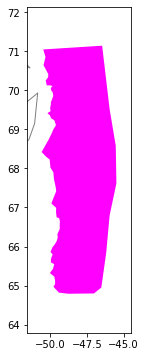

In [7]:
buffer = gdf.buffer(1) #create buffer for plot bounds
envelope = buffer.envelope  
bounds = envelope.bounds

# Load "Natural Earth” countries dataset, bundled with GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Overlay glacier outline
f, ax = plt.subplots(1, figsize=(12, 6))
world.plot(ax=ax, facecolor='white', edgecolor='gray')
gdf.plot(ax=ax, cmap='spring')
ax.set_ylim([bounds.miny[0], bounds.maxy[0]])
ax.set_xlim([bounds.minx[0], bounds.maxx[0]]);

In [18]:
version = granule_id[30:33]
capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{version}.xml'

# Create session to store cookie and pass credentials to capabilities url
session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(earthdatacreds.uid,earthdatacreds.pwd))

root = ET.fromstring(response.content)

#collect lists with each service option
subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# this is for getting possible variable values
if len(subagent) > 0 :

    # variable subsetting
    variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
    variables_raw = [variables[i]['value'] for i in range(len(variables))]
    variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
    variable_vals = [v.replace(':', '/') for v in variables_join]
    vars_gtx = list(np.unique(np.array([re.sub('/gt[123][rl]', '/gtx', x) for x in variable_vals])))

#     # reformatting
#     formats = [Format.attrib for Format in root.iter('Format')]
#     format_vals = [formats[i]['value'] for i in range(len(formats))]
#     format_vals.remove('')

#     # reprojection options
#     projections = [Projection.attrib for Projection in root.iter('Projection')]

In [19]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
var_list_subsetting = intersection(variable_vals,var_list)

In [9]:
# print variables (gtx subbed in for the specific beams)
# vars_gtx
# variable_vals

In [21]:
if len(subagent) < 1 :
    print('No services exist for', short_name, 'version', latest_version)
    agent = 'NO'
    coverage,Boundingshape = '',''
else:
    agent = ''
    subdict = subagent[0]
    if subdict['spatialSubsettingShapefile'] == 'true':
        Boundingshape = geojson
    else:
        Boundingshape = ''
    coverage = ','.join(var_list_subsetting)

In [22]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'
page_size = 100
request_mode = 'stream'
page_num = math.ceil(len(granules)/page_size)

param_dict = {'short_name': short_name, 
              'producer_granule_id': granule_id,
              'version': version,  
              'polygon': polygon,
              'Boundingshape': Boundingshape,  
              'Coverage': coverage, 
              'page_size': page_size, 
              'request_mode': request_mode, 
              'agent': agent, 
              'email': 'yes'}

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

#Print API base URL + request parameters
endpoint_list = [] 
for i in range(page_num):
    page_val = i + 1
    API_request = api_request = f'{base_url}?{param_string}&page_num={page_val}'
    endpoint_list.append(API_request)

print('\nAPI request URL:')
print(*endpoint_list, sep = "\n") 


API request URL:
https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL03&producer_granule_id=ATL03_20210715182907_03381203_005_01.h5&version=005&polygon=-50.14632142526025,70.41217197695167,-50.32210267526025,70.24946638923085,-50.25069154244775,70.12471900869032,-49.86067689401025,70.10977336216563,-49.97603333932275,70.05175706967246,-49.81123841744775,69.85593384548227,-49.97603333932275,69.6868925196855,-49.987872551252984,69.46430946458665,-50.207599113752984,69.41415021565054,-49.735187004377984,69.23182582544285,-49.625323723127984,69.10680792033415,-50.603106926252984,68.41839417137938,-50.053790520002984,68.22766675217088,-49.998858879377984,68.0188934736755,-49.801104973127984,67.89933200740279,-49.60918763541066,67.41285267153148,-49.93328431509816,67.100678171543,-49.60918763541066,66.98927461109227,-49.57516582234763,66.74687675567,-49.40487773641013,66.72518052309654,-49.35543925984763,66.6447381360437,-49.36642558797263,66.44797066124347,-49.52987706420915,66.313600

In [12]:
# Create an output folder if the folder does not already exist.

path = str(os.getcwd() + granule_output_path)
if not os.path.exists(path):
    os.mkdir(path)

# Different access methods depending on request mode:

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    print('Requesting...')
    request = session.get(base_url, params=param_dict)
    print('HTTP response from order response URL: ', request.status_code)
    request.raise_for_status()
    d = request.headers['content-disposition']
    fname = re.findall('filename=(.+)', d)
    dirname = os.path.join(path,fname[0].strip('\"'))
    print('Downloading...')
    open(dirname, 'wb').write(request.content)
    print('Data request', page_val, 'is complete.')

# Unzip outputs
for z in os.listdir(path): 
    if z.endswith('.zip'): 
        zip_name = path + "/" + z 
        zip_ref = zipfile.ZipFile(zip_name) 
        zip_ref.extractall(path) 
        zip_ref.close() 
        os.remove(zip_name) 
            
# Clean up Outputs folder by removing individual granule folders 
for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))    

Order:  1
Requesting...
HTTP response from order response URL:  200
Downloading...
Data request 1 is complete.


In [13]:
available = ['apple','banana','orange']
requested = ['orange','banana','peach']
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersection(available,requested)

['banana', 'orange']

In [18]:
','.join(coverage)

'/ancillary_data/atlas_sdp_gps_epoch,/orbit_info/rgt,/orbit_info/cycle_number,/orbit_info/sc_orient,/gt1l/geolocation/ph_index_beg,/gt1r/geolocation/ph_index_beg,/gt2l/geolocation/ph_index_beg,/gt2r/geolocation/ph_index_beg,/gt3l/geolocation/ph_index_beg,/gt3r/geolocation/ph_index_beg,/gt1l/geolocation/segment_dist_x,/gt1r/geolocation/segment_dist_x,/gt2l/geolocation/segment_dist_x,/gt2r/geolocation/segment_dist_x,/gt3l/geolocation/segment_dist_x,/gt3r/geolocation/segment_dist_x,/gt1l/geolocation/segment_length,/gt1r/geolocation/segment_length,/gt2l/geolocation/segment_length,/gt2r/geolocation/segment_length,/gt3l/geolocation/segment_length,/gt3r/geolocation/segment_length,/gt1l/geophys_corr/dem_h,/gt1r/geophys_corr/dem_h,/gt2l/geophys_corr/dem_h,/gt2r/geophys_corr/dem_h,/gt3l/geophys_corr/dem_h,/gt3r/geophys_corr/dem_h,/gt1l/geophys_corr/geoid,/gt1r/geophys_corr/geoid,/gt2l/geophys_corr/geoid,/gt2r/geophys_corr/geoid,/gt3l/geophys_corr/geoid,/gt3r/geophys_corr/geoid,/gt1l/bckgrd_atlas

In [11]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

#Set the request mode to asynchronous if the number of granules is over 100, otherwise synchronous is enabled by default
if len(granules) > 100:
    request_mode = 'async'
    page_size = 2000
else: 
    page_size = 100
    request_mode = 'stream'

#Determine number of orders needed for requests over 2000 granules. 
page_num = math.ceil(len(granules)/page_size)

print('There will be', page_num, 'total order(s) processed for our', short_name, 'request.')

There will be 1 total order(s) processed for our ATL03 request.


In [14]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'
page_size = 100
request_mode = 'stream'
page_num = math.ceil(len(granules)/page_size)

param_dict = {'short_name': short_name, 
              'version': version,  
              'polygon': polygon,
              'Boundingshape': Boundingshape,  
              'Coverage': coverage, 
              'page_size': page_size, 
              'request_mode': request_mode, 
              'agent': agent, 
              'email': 'yes'}

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

In [15]:
param_dict

{'short_name': 'ATL03',
 'version': '005',
 'polygon': '-50.14632142526025,70.41217197695167,-50.32210267526025,70.24946638923085,-50.25069154244775,70.12471900869032,-49.86067689401025,70.10977336216563,-49.97603333932275,70.05175706967246,-49.81123841744775,69.85593384548227,-49.97603333932275,69.6868925196855,-49.987872551252984,69.46430946458665,-50.207599113752984,69.41415021565054,-49.735187004377984,69.23182582544285,-49.625323723127984,69.10680792033415,-50.603106926252984,68.41839417137938,-50.053790520002984,68.22766675217088,-49.998858879377984,68.0188934736755,-49.801104973127984,67.89933200740279,-49.60918763541066,67.41285267153148,-49.93328431509816,67.100678171543,-49.60918763541066,66.98927461109227,-49.57516582234763,66.74687675567,-49.40487773641013,66.72518052309654,-49.35543925984763,66.6447381360437,-49.36642558797263,66.44797066124347,-49.52987706420915,66.31360064609107,-49.560515197476555,66.14900007845858,-49.994475158414055,65.86083805358744,-49.8516528927890

In [ ]:
sys.path.insert(1, '/Users/parndt/Vault/') # the path here needs to match the one on which earthdatacreds.py is stored
import earthdatacreds
print(earthdatacreds.name,earthdatacreds.organization,earthdatacreds.uid,earthdatacreds.email,sep=' - ')

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
short_name = 'ATL03'
response = requests.get(cmr_collections_url, params={'short_name':short_name})
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number
versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

In [ ]:
# example from greenland 2021
start_date = '2021-07-15'
start_time = '00:00:00'
end_date = '2021-07-15'
end_time = '23:59:59'
temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
bbox = [-51.0, 65, -48.0, 70]
bb = '%g,%g,%g,%g' % tuple(bbox)
bounding_box = '-51.0,65,-48.0,70'
print(temporal)
print(bb)

In [ ]:
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
search_params = {
    'short_name': short_name,
    # 'version': latest_version,
    # 'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'producer_granule_id': 'ATL03_20210715182907_03381203_005_01.h5',
    #'bounding_box': bounding_box
    }
granules = []
headers={'Accept': 'application/json'}
while True:
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)
    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break
    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1
print('There are', len(granules), 'granules of', short_name, 'version', latest_version, 'over this area/time of interest.')
granule_sizes = [float(granule['granule_size']) for granule in granules]
print(f'The average size of each granule is {mean(granule_sizes):.2f} MB.')
print(f'The total size of all {len(granules)} granules is {sum(granule_sizes):.2f} MB.')

In [ ]:
results

In [ ]:
cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
short_name = 'ATL03'
response = requests.get(cmr_collections_url, params={'short_name':short_name})
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number
versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

In [ ]:
sys.path.insert(1, '/Users/parndt/Vault/') # the path here needs to match the one on which earthdatacreds.py is stored
import earthdatacreds
print(earthdatacreds.name,earthdatacreds.organization,earthdatacreds.uid,earthdatacreds.email,sep=' - ')

short_name = 'ATL03'
# Get json response from CMR collection metadata
params = {
    'short_name': short_name
}
cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number
versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)